## Introduction

Aim of this notebook to develop a model to predict the risk of cardio-vascular disease using a a set of health indicators. Original dataset is from [Kaggle](https://www.kaggle.com/datasets/alphiree/cardiovascular-diseases-risk-prediction-dataset) and it consists of data imported from the the Behavioral Risk Factor Surveillance System (BRFSS) that collected state data about U.S. residents regarding their health-related risk behaviors, chronic health conditions, and use of preventive services. The preprocessed dataset has 19 variables that relates to lifestyle factors of a person that can be contributed to being at risk with any form of Cardiovascular Diseases.

### 1. Loading Data from .CSV File Downloaded

In [1]:
import numpy as np
import pandas as pd

cvd_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CVD_Risk_Prediction/Data/CVD_cleaned.csv")

cvd_data.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


### 2. Categorigal Data Encoding
A breif walkthrough of the dataset reveals that there are 12 categorical variables and the rest are numerical variables. Among the categorical variables, one is binary and the rest are ordinal.
#### 2.1 Detect Unique Values of Ordinal Variable for Encoding
The unique values of the ordinal variables can be detected using the following code.

In [2]:

print("Unique Values of General_Health Column: ", cvd_data['General_Health'].unique())
print("Unique Values of Checkup Column: ", cvd_data['Checkup'].unique())
print("Unique Values of Age_Category Column: ", cvd_data['Age_Category'].unique())
print("Unique Values of Exercise Column: ", cvd_data['Exercise'].unique())
print("Unique Values of Heart_Disease Column: ", cvd_data['Heart_Disease'].unique())
print("Unique Values of Skin_Cancer Column: ", cvd_data['Skin_Cancer'].unique())
print("Unique Values of Other_Cancer Column: ", cvd_data['Other_Cancer'].unique())
print("Unique Values of Depression Column: ", cvd_data['Depression'].unique())
print("Unique Values of Diabetes Column: ", cvd_data['Diabetes'].unique())
print("Unique Values of Arthritis Column: ", cvd_data['Arthritis'].unique())
print("Unique Values of Smoking_History Column: ", cvd_data['Smoking_History'].unique())

Unique Values of General_Health Column:  ['Poor' 'Very Good' 'Good' 'Fair' 'Excellent']
Unique Values of Checkup Column:  ['Within the past 2 years' 'Within the past year' '5 or more years ago'
 'Within the past 5 years' 'Never']
Unique Values of Age_Category Column:  ['70-74' '60-64' '75-79' '80+' '65-69' '50-54' '45-49' '18-24' '30-34'
 '55-59' '35-39' '40-44' '25-29']
Unique Values of Exercise Column:  ['No' 'Yes']
Unique Values of Heart_Disease Column:  ['No' 'Yes']
Unique Values of Skin_Cancer Column:  ['No' 'Yes']
Unique Values of Other_Cancer Column:  ['No' 'Yes']
Unique Values of Depression Column:  ['No' 'Yes']
Unique Values of Diabetes Column:  ['No' 'Yes' 'No, pre-diabetes or borderline diabetes'
 'Yes, but female told only during pregnancy']
Unique Values of Arthritis Column:  ['Yes' 'No']
Unique Values of Smoking_History Column:  ['Yes' 'No']


#### 2.2 Encode Categorical Variables

Ordinal catergorical columns are encoded with OrdinalEncoder with intuitively sorted values for each column. Binar catergorical column is encoded with OneHotEncorder. All the other columns are passed through. Transformation is realised using a ColumnTransformer. The ColumnTransformer is fit and transformed over all data including training and testing data. For a deployment of a model, it can be made a part of a model pipeline and fit on the traning data only.

In [3]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

ordinal_cols = ["General_Health",
                "Checkup",
                "Age_Category",
                "Diabetes",
                "Exercise",
                "Heart_Disease",
                "Skin_Cancer",
                "Other_Cancer",
                "Depression",
                "Arthritis",
                "Smoking_History"]

ordinal_categories = [
     ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'],
     ['Never', '5 or more years ago', 'Within the past 5 years', 'Within the past 2 years', 'Within the past year'],
     ['18-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79','80+'],
     ["No","No, pre-diabetes or borderline diabetes","Yes, but female told only during pregnancy","Yes"],
     ["No","Yes"],
     ["No","Yes"],
     ["No","Yes"],
     ["No","Yes"],
     ["No","Yes"],
     ["No","Yes"],
     ["No","Yes"]]

onehot_cols = ["Sex"]

or_enc = OrdinalEncoder(categories=ordinal_categories)
onehot_enc = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

column_transformer = ColumnTransformer(transformers=[("ordinal", or_enc, ordinal_cols),
                                                     ("one_hot", onehot_enc, onehot_cols)],
                                        remainder="passthrough",
                                        verbose_feature_names_out=False,).set_output(transform="pandas")

transformed_cvd_train = column_transformer.fit_transform(cvd_data)

### 3. Generate Training Set and the Holdout Testing Set

Holdout testing set is used for model performance evaluation after hyper-parameter tuning. 

In [4]:
cvd_Y = transformed_cvd_train["Heart_Disease"]
cvd_X = transformed_cvd_train.drop("Heart_Disease",axis=1)

from sklearn.model_selection import train_test_split
cvd_train_vali_X,cvd_holdout_X, cvd_train_vali_Y,cvd_holdout_Y = train_test_split(cvd_X,cvd_Y, test_size=0.3, random_state=0)

### 4. Checking for Outliers

#### 4.1 Plot Histograms of Indivigual Numerical Variables
This allows to detect outliers that can be identified through a single variable.

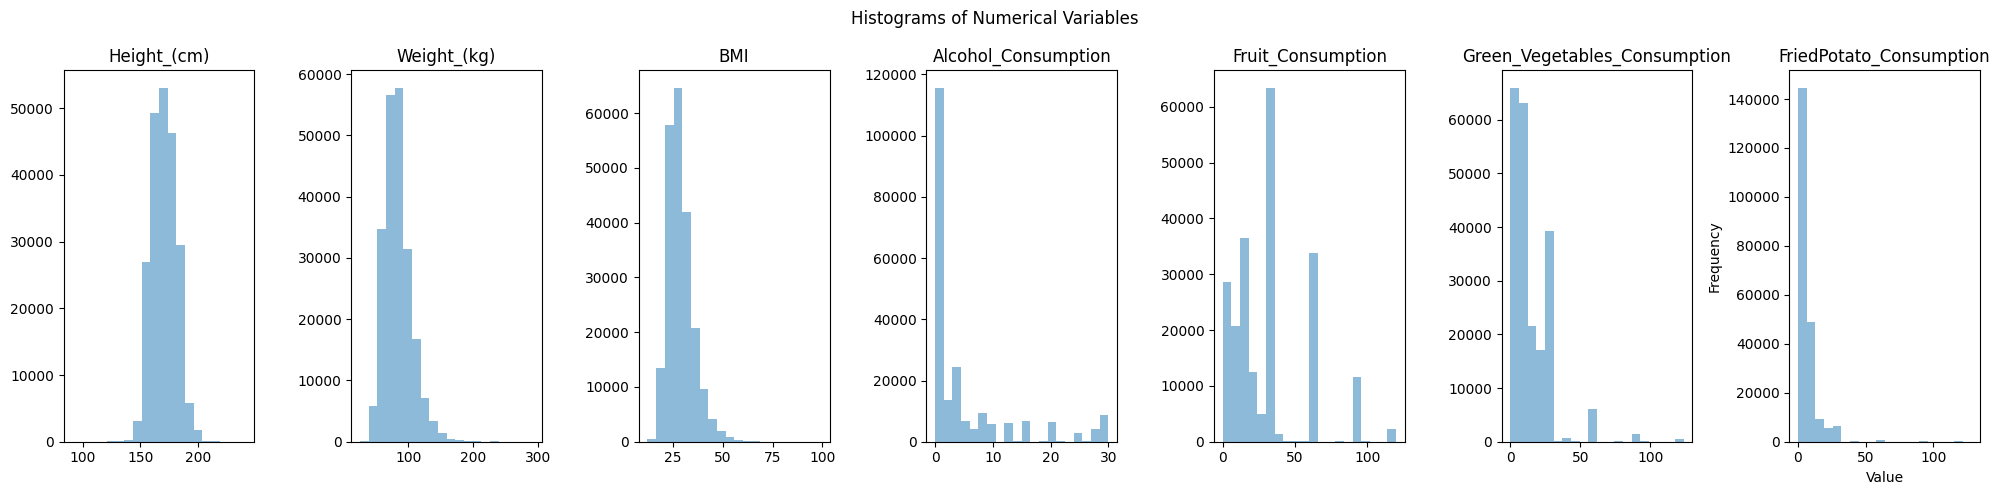

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 7, figsize=(20, 5))

# Plot histograms for each variable on separate subplots
axes[0].hist(cvd_train_vali_X["Height_(cm)"], bins=20, alpha=0.5)
axes[0].set_title("Height_(cm)")

axes[1].hist(cvd_train_vali_X["Weight_(kg)"], bins=20, alpha=0.5)
axes[1].set_title("Weight_(kg)")

axes[2].hist(cvd_train_vali_X["BMI"], bins=20, alpha=0.5)
axes[2].set_title("BMI")

axes[3].hist(cvd_train_vali_X["Alcohol_Consumption"], bins=20, alpha=0.5)
axes[3].set_title("Alcohol_Consumption")

axes[4].hist(cvd_train_vali_X["Fruit_Consumption"], bins=20, alpha=0.5)
axes[4].set_title("Fruit_Consumption")

axes[5].hist(cvd_train_vali_X["Green_Vegetables_Consumption"], bins=20, alpha=0.5)
axes[5].set_title("Green_Vegetables_Consumption")

axes[6].hist(cvd_train_vali_X["FriedPotato_Consumption"], bins=20, alpha=0.5)
axes[6].set_title("FriedPotato_Consumption")

# Add labels and a title to the entire figure
fig.suptitle('Histograms of Numerical Variables')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Adjust spacing between subplots for better readability
plt.tight_layout()

# Show the plot
plt.show()

Not many outliers that can be detected through a single variable, are present in the dataset. Therefore, a Isolation-Forest based outlier detection is performed next.

#### 4.2 Isolation-Forest Based Outlier Analysis

Number of outliers detected for contamination level 1e-06:  1


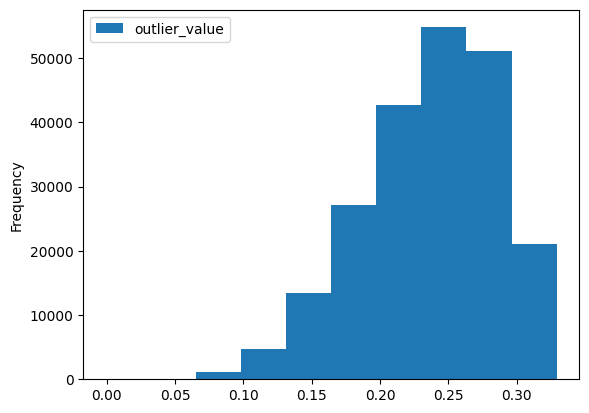

In [7]:
from sklearn.ensemble import IsolationForest

cvd_train_vali = cvd_train_vali_X.copy()
cvd_train_vali["Heart_Disease"] = cvd_train_vali_Y

contamination = 0.000001
outlier_model = IsolationForest(random_state=0,contamination=contamination)
outlier_predict = outlier_model.fit_predict(cvd_train_vali)
outlier_value = outlier_model.decision_function(cvd_train_vali)
cvd_train_vali_outlier_data = cvd_train_vali.copy()
cvd_train_vali_outlier_data["outlier"] = outlier_predict
cvd_train_vali_outlier_data["outlier_value"] = outlier_value

count_outliers = cvd_train_vali_outlier_data[cvd_train_vali_outlier_data["outlier"] == -1].shape[0]
print(f"Number of outliers detected for contamination level {contamination}: ", count_outliers)
cvd_train_vali_outlier_data.plot(y="outlier_value", kind="hist")

cvd_train_vali_X = cvd_train_vali_outlier_data[cvd_train_vali_outlier_data["outlier"] == 1].drop(["outlier", "outlier_value", "Heart_Disease"],axis=1)
cvd_train_vali_Y = cvd_train_vali_outlier_data[cvd_train_vali_outlier_data["outlier"] == 1]["Heart_Disease"]

### 5. (Obtional) Loading Saved Models, Performance Metrices and Used Hyper-paramter Search Grids

After hyper-parameter tuning of each model, the validation score, training score, testing score, the model and the search grid used for hyper-paramter tuning is saved to "Dump" folder as indivigual files for each model. The following code tries to load the files into variable names. If the loading is successful a boolean variable for each model is set to True. Upon a failure during saved file loading the boolean variable is set to False. These boolean variable can later be used during model training step to avoid unecessory training of models on same hyper-parameter grid, which may save computational time.

In [38]:
import pickle
import os.path

lr_dump_path  = '/content/drive/MyDrive/Colab Notebooks/CVD_Risk_Prediction/Dump/lr_dump.pkl'
rf_dump_path  = '/content/drive/MyDrive/Colab Notebooks/CVD_Risk_Prediction/Dump/rf_dump.pkl'
erf_dump_path = '/content/drive/MyDrive/Colab Notebooks/CVD_Risk_Prediction/Dump/erf_dump.pkl'
ab_dump_path  = '/content/drive/MyDrive/Colab Notebooks/CVD_Risk_Prediction/Dump/ab_dump.pkl'
xg_dump_path  = '/content/drive/MyDrive/Colab Notebooks/CVD_Risk_Prediction/Dump/xg_dump.pkl'
nn_dump_path  = '/content/drive/MyDrive/Colab Notebooks/CVD_Risk_Prediction/Dump/nn_dump.pkl'
vc_dump_path  = '/content/drive/MyDrive/Colab Notebooks/CVD_Risk_Prediction/Dump/vc_dump.pkl'
sc_dump_path  = '/content/drive/MyDrive/Colab Notebooks/CVD_Risk_Prediction/Dump/sc_dump.pkl'
crs_dump_path = '/content/drive/MyDrive/Colab Notebooks/CVD_Risk_Prediction/Dump/crs_dump.pkl'
cxg_dump_path = '/content/drive/MyDrive/Colab Notebooks/CVD_Risk_Prediction/Dump/cxg_dump.pkl'

try:
   with open(lr_dump_path, 'rb') as f:
      best_validation_score_lr ,  best_train_score_lr , best_testing_score_lr, best_params_lr, best_model_lr, saved_param_grid_lr = pickle.load(f)
   load_success_lr = True
except:
   load_success_lr = False

try:
   with open(rf_dump_path, 'rb') as f:
      best_validation_score_rf ,  best_train_score_rf , best_testing_score_rf, best_params_rf, best_model_rf, saved_param_grid_rf = pickle.load(f)
   load_success_rf = True
except:
   load_success_rf = False

try:
   with open(erf_dump_path, 'rb') as f:
      best_validation_score_erf ,  best_train_score_erf , best_testing_score_erf, best_params_erf, best_model_erf, saved_param_grid_erf = pickle.load(f)
   load_success_erf = True
except:
   load_success_erf = False

try:
   with open(ab_dump_path, 'rb') as f:
      best_validation_score_ab ,  best_train_score_ab , best_testing_score_ab, best_params_ab, best_model_ab, saved_param_grid_ab = pickle.load(f)
   load_success_ab = True
except:
   load_success_ab = False

try:
   with open(xg_dump_path, 'rb') as f:
      best_validation_score_xg ,  best_train_score_xg , best_testing_score_xg, best_params_xg, best_model_xg, saved_param_grid_xg = pickle.load(f)
   load_success_xg = True
except:
   load_success_xg = False

try:
   with open(nn_dump_path, 'rb') as f:
      best_validation_score_nn ,  best_train_score_nn , best_testing_score_nn, best_params_nn, best_model_nn, saved_param_grid_nn = pickle.load(f)
   load_success_nn = True
except:
   load_success_nn = False

try:
   with open(vc_dump_path, 'rb') as f:
      best_validation_score_vc ,  best_train_score_vc , best_testing_score_vc, best_params_vc, best_model_vc, saved_param_grid_vc = pickle.load(f)
   load_success_vc = True
except:
   load_success_vc = False

try:
   with open(sc_dump_path, 'rb') as f:
      best_validation_score_sc ,  best_train_score_sc , best_testing_score_sc, best_params_sc, best_model_sc, saved_param_grid_sc = pickle.load(f)
   load_success_sc = True
except:
   load_success_sc = False

try:
   with open(cxg_dump_path, 'rb') as f:
      best_validation_score_cxg ,  best_train_score_cxg , best_testing_score_cxg, best_params_cxg, best_model_cxg, saved_param_grid_cxg = pickle.load(f)
   load_success_cxg = True
except:
   load_success_cxg = False

try:
   with open(crs_dump_path, 'rb') as f:
      best_validation_score_crs ,  best_train_score_crs , best_testing_score_crs, best_params_crs, best_model_crs, saved_param_grid_crs = pickle.load(f)
   load_success_crs = True
except:
   load_success_crs = False

### 6. Basic Model Training with Hyper-paramerter Tuning

First each model and the current hyper-parameter search grid are instantiated. Then it is checked whether model re-training is needed. Model re-training is needed at the first run of the notebook. However, a model re-training is not needed if the loading of the saved model, its performace metrices and hyper-parameter search grid is successful and the loaded previous hyper-parameter search grid is the same as the current grid. This step saves a considerable amount of computation time in an event model re-training is not necessory. 

#### 6.1 A Pipeline of a Standard-Scalar followed by a Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

scaler = StandardScaler()
scale_cols = list(cvd_train_vali_X.columns)
cols_trfrm = ColumnTransformer(transformers=[("scaler", scaler, scale_cols)],
                               remainder="passthrough",
                               verbose_feature_names_out=False)
model_lr=LogisticRegression()
model_lr_pipeline = Pipeline(steps=[("cols_transform", cols_trfrm), ("logistic", model_lr)])

param_grid_lr = {'logistic__C':np.arange(0.1,2,0.1)}

re_train = False
if load_success_lr:
  try:
    for key, value in param_grid_lr.items():
      if ~(np.all(param_grid_lr[key] == saved_param_grid_lr[key])):
        re_train = True
        break
  except:
    re_train = True
else:
  re_train = True

if re_train:
  clf_lr = GridSearchCV(model_lr_pipeline, param_grid_lr, return_train_score=True, scoring="accuracy", verbose=3)
  clf_lr.fit(cvd_train_vali_X, cvd_train_vali_Y)

  train_scores_lr = clf_lr.cv_results_['mean_train_score']
  validation_scores_lr = clf_lr.cv_results_['mean_test_score']

  best_validation_score_lr = validation_scores_lr.max()
  best_train_score_lr = train_scores_lr[validation_scores_lr.argmax()]
  best_params_lr = clf_lr.best_params_
  best_model_lr = clf_lr.best_estimator_
  best_testing_score_lr = accuracy_score(cvd_holdout_Y,best_model_lr.predict(cvd_holdout_X))

  saved_param_grid_lr = param_grid_lr
  with open(lr_dump_path, 'wb') as f:
    pickle.dump([best_validation_score_lr ,  best_train_score_lr , best_testing_score_lr, best_params_lr, best_model_lr,saved_param_grid_lr], f)

#### 6.2 Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

model_rf=RandomForestClassifier(random_state=0)
param_grid_rf = {'n_estimators':np.array([5,10,20]),
                 'max_features':np.arange(1,11,2),
                 'max_depth':np.arange(1,11,3)}

re_train = False
if load_success_rf:
  try:
    for key, value in param_grid_rf.items():
      if ~(np.all(param_grid_rf[key] == saved_param_grid_rf[key])):
        re_train = True
        break
  except:
    re_train = True
else:
  re_train = True

if re_train:
  clf_rf = GridSearchCV(model_rf, param_grid_rf, return_train_score=True, scoring="accuracy", verbose=3)
  clf_rf.fit(cvd_train_vali_X, cvd_train_vali_Y)

  train_scores_rf = clf_rf.cv_results_['mean_train_score']
  validation_scores_rf = clf_rf.cv_results_['mean_test_score']

  best_validation_score_rf = validation_scores_rf.max()
  best_train_score_rf = train_scores_rf[validation_scores_rf.argmax()]
  best_params_rf = clf_rf.best_params_
  best_model_rf = clf_rf.best_estimator_
  best_testing_score_rf = accuracy_score(cvd_holdout_Y,best_model_rf.predict(cvd_holdout_X))

  saved_param_grid_rf = param_grid_rf
  with open(rf_dump_path, 'wb') as f:
    pickle.dump([best_validation_score_rf,  best_train_score_rf, best_testing_score_rf, best_params_rf, best_model_rf, saved_param_grid_rf], f)

#### 6.3 Extra-Trees Classifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

model_erf=ExtraTreesClassifier(random_state=0)
param_grid_erf = {'n_estimators':np.array([5,10,20]),
                 'max_features':np.arange(1,11,2),
                 'max_depth':np.arange(1,11,3)}

re_train = False
if load_success_erf:
  try:
    for key, value in param_grid_erf.items():
      if ~(np.all(param_grid_erf[key] == saved_param_grid_erf[key])):
        re_train = True
        break
  except:
    re_train = True
else:
  re_train = True

if re_train:
  clf_erf = GridSearchCV(model_erf, param_grid_erf, return_train_score=True, scoring="accuracy", verbose=3)
  clf_erf.fit(cvd_train_vali_X, cvd_train_vali_Y)

  train_scores_erf = clf_erf.cv_results_['mean_train_score']
  validation_scores_erf = clf_erf.cv_results_['mean_test_score']

  best_validation_score_erf = validation_scores_erf.max()
  best_train_score_erf = train_scores_erf[validation_scores_erf.argmax()]
  best_params_erf = clf_erf.best_params_
  best_model_erf = clf_erf.best_estimator_
  best_testing_score_erf = accuracy_score(cvd_holdout_Y,best_model_erf.predict(cvd_holdout_X))

  saved_param_grid_erf = param_grid_erf
  with open(erf_dump_path, 'wb') as f:
    pickle.dump([best_validation_score_erf,  best_train_score_erf, best_testing_score_erf, best_params_erf, best_model_erf, saved_param_grid_erf], f)

#### 6.4 AdaBoost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

model_ab=AdaBoostClassifier(random_state=0)
param_grid_ab = {'n_estimators':np.array([10,30,50,80,100]),
                 'learning_rate':np.arange(0.1,2,0.2)}

re_train = False
if load_success_ab:
  try:
    for key, value in param_grid_ab.items():
      if ~(np.all(param_grid_ab[key] == saved_param_grid_ab[key])):
        re_train = True
        break
  except:
    re_train = True
else:
  re_train = True

if re_train:
  clf_ab = GridSearchCV(model_ab, param_grid_ab, return_train_score=True, scoring="accuracy", verbose=3)
  clf_ab.fit(cvd_train_vali_X, cvd_train_vali_Y)

  train_scores_ab = clf_ab.cv_results_['mean_train_score']
  validation_scores_ab = clf_ab.cv_results_['mean_test_score']

  best_validation_score_ab = validation_scores_ab.max()
  best_train_score_ab = train_scores_ab[validation_scores_ab.argmax()]
  best_params_ab = clf_ab.best_params_
  best_model_ab = clf_ab.best_estimator_
  best_testing_score_ab = accuracy_score(cvd_holdout_Y,best_model_ab.predict(cvd_holdout_X))

  saved_param_grid_ab = param_grid_ab
  with open(ab_dump_path, 'wb') as f:
    pickle.dump([best_validation_score_ab ,  best_train_score_ab , best_testing_score_ab, best_params_ab, best_model_ab, saved_param_grid_ab], f)

#### 6.5 XGBoost Classifier

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

model_xg = XGBClassifier(random_state=0)
param_grid_xg = {'n_estimators':np.array([5,10,20]),
                 'learning_rate':np.arange(0.1,2,0.2),
                 'max_depth':np.arange(1,11,3)}

re_train = False
if load_success_xg:
  try:
    for key, value in param_grid_xg.items():
      if ~(np.all(param_grid_xg[key] == saved_param_grid_xg[key])):
        re_train = True
        break
  except:
    re_train = True
else:
  re_train = True

if re_train:
  clf_xg = GridSearchCV(model_xg, param_grid_xg, return_train_score=True, scoring="accuracy", verbose=3)
  clf_xg.fit(cvd_train_vali_X, cvd_train_vali_Y)

  train_scores_xg = clf_xg.cv_results_['mean_train_score']
  validation_scores_xg = clf_xg.cv_results_['mean_test_score']

  best_validation_score_xg = validation_scores_xg.max()
  best_train_score_xg = train_scores_xg[validation_scores_xg.argmax()]
  best_params_xg = clf_xg.best_params_
  best_model_xg = clf_xg.best_estimator_
  best_testing_score_xg = accuracy_score(cvd_holdout_Y,best_model_xg.predict(cvd_holdout_X))

  saved_param_grid_xg = param_grid_xg
  with open(xg_dump_path, 'wb') as f:
    pickle.dump([best_validation_score_xg ,  best_train_score_xg , best_testing_score_xg, best_params_xg, best_model_xg, saved_param_grid_xg], f)

#### 6.6 Neural-Network Classifier from Scikit Learn

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

model_nn = MLPClassifier(random_state=0)
param_grid_nn = {'hidden_layer_sizes':np.array([50,75,100,125]),
                 'max_iter':np.array([50,100,150,200,250])}

re_train = False
if load_success_nn:
  try:
    for key, value in param_grid_nn.items():
      if ~(np.all(param_grid_nn[key] == saved_param_grid_nn[key])):
        re_train = True
        break
  except:
    re_train = True
else:
  re_train = True

if re_train:
  clf_nn = GridSearchCV(model_nn, param_grid_nn, return_train_score=True, scoring="accuracy", verbose=3)
  clf_nn.fit(cvd_train_vali_X, cvd_train_vali_Y)

  train_scores_nn = clf_nn.cv_results_['mean_train_score']
  validation_scores_nn = clf_nn.cv_results_['mean_test_score']

  best_validation_score_nn = validation_scores_nn.max()
  best_train_score_nn = train_scores_nn[validation_scores_nn.argmax()]
  best_params_nn = clf_nn.best_params_
  best_model_nn = clf_nn.best_estimator_
  best_testing_score_nn = accuracy_score(cvd_holdout_Y,best_model_nn.predict(cvd_holdout_X))

  saved_param_grid_nn = param_grid_nn
  with open(nn_dump_path, 'wb') as f:
    pickle.dump([best_validation_score_nn ,  best_train_score_nn , best_testing_score_nn, best_params_nn, best_model_nn, saved_param_grid_nn], f)

Testing accuracy of each model on the hold-out test are as follows.

| Model                 | Accuracy    |
| --------------------- | ----------- |
| 1. Logistic Regression| 0.9196067   |
| 2. Random Forest      | 0.9196498   |
| 3. ExtraTrees         | 0.9195311   |
| 4. AdaBoost           | 0.9196714   |
| 5. XGBoost            | 0.9199736   |
| 6. Neural Network     | 0.9198657   |

### 7. Ensemble Classifiers

Trying to combine the based models to achive a higher testing accuracy.

#### 7.1 Voting Classifier

Voting classifier combining the best Random-Forest, XGBoost, Neural-Network classifiers found in step-6 previously.

In [ ]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

est_list_rf1 = RandomForestClassifier(random_state=0)
est_list_rf1 = est_list_rf1.set_params(**best_params_rf)

est_list_xg1 = XGBClassifier(random_state=0, max_depth=10)
est_list_xg1 = est_list_xg1.set_params(**best_params_xg)

est_list_nn1 = MLPClassifier(random_state=0)
est_list_nn1 = est_list_nn1.set_params(**best_params_nn)

est_list = [('rf1', est_list_rf1),
            ('xg1', est_list_xg1),
            ('nn1', est_list_nn1)]

model_vc = VotingClassifier(estimators=est_list, voting='soft', verbose=3)

weights_1d = np.linspace(0,1,5).reshape(-1,1)
all_combina_weights = np.array(np.meshgrid(weights_1d, weights_1d, weights_1d)).T.reshape(-1,3)
weight_grid = []
for i in np.arange(1,all_combina_weights.shape[0]):
  if (sum(all_combina_weights[i,:])==1):
    weight_grid.append(all_combina_weights[i,:])

param_grid_vc = {'weights':weight_grid}

re_train = False
if load_success_vc:
  try:
    for key, value in param_grid_vc.items():
      if (len(param_grid_vc[key]) != len(saved_param_grid_vc[key])):
        re_train = True
        break
      else:
        for i in range(len(param_grid_vc[key])):
          if ~(np.all(param_grid_vc[key][i] == saved_param_grid_vc[key][i])):
            re_train = True
            break
  except:
    re_train = True
else:
  re_train = True

if re_train:
  clf_vc = GridSearchCV(model_vc, param_grid_vc, return_train_score=True, scoring="accuracy", verbose=3)
  clf_vc.fit(cvd_train_vali_X, cvd_train_vali_Y)

  train_scores_vc = clf_vc.cv_results_['mean_train_score']
  validation_scores_vc = clf_vc.cv_results_['mean_test_score']

  best_validation_score_vc = validation_scores_vc.max()
  best_train_score_vc = train_scores_vc[validation_scores_vc.argmax()]
  best_params_vc = clf_vc.best_params_
  best_model_vc = clf_vc.best_estimator_
  best_testing_score_vc = accuracy_score(cvd_holdout_Y,best_model_vc.predict(cvd_holdout_X))

  saved_param_grid_vc = param_grid_vc
  with open(vc_dump_path, 'wb') as f:
      pickle.dump([best_validation_score_vc ,  best_train_score_vc , best_testing_score_vc, best_params_vc, best_model_vc, saved_param_grid_vc], f)

#### 7.2 Stacked Classifier

Stacked classifier combining the best AdaBoost, XGBoost, Neural-Network classifiers found in step-6 previously. The final estimator of the stack is a Random-Forest.

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

est_list_rf1 = RandomForestClassifier(random_state=0)
est_list_rf1 = est_list_rf1.set_params(**best_params_rf)

est_list_xg1 = XGBClassifier(random_state=0)
est_list_xg1 = est_list_xg1.set_params(**best_params_xg)

est_list_ab1 = AdaBoostClassifier(random_state=0)
est_list_ab1 = est_list_ab1.set_params(**best_params_ab)

est_list_nn1 = MLPClassifier(random_state=0)
est_list_nn1 = est_list_nn1.set_params(**best_params_nn)

est_list = [('ab1', est_list_ab1),
            ('xg1', est_list_xg1),
            ('nn1', est_list_nn1)]

model_sc = StackingClassifier(estimators=est_list , final_estimator=RandomForestClassifier(max_depth=7), passthrough=True, verbose=3)

if load_success_sc:
  re_train = False
else:
  re_train = True

if re_train:
  cv_results_sc = cross_validate(estimator=model_sc, X=cvd_train_vali_X, y=cvd_train_vali_Y, return_train_score=True, verbose=3)

  best_validation_score_sc = cv_results_sc['test_score'].mean()
  best_train_score_sc = cv_results_sc['train_score'].mean()
  best_params_sc = []
  best_model_sc = model_sc.fit(X=cvd_train_vali_X, y=cvd_train_vali_Y)
  best_testing_score_sc = accuracy_score(cvd_holdout_Y,best_model_sc.predict(cvd_holdout_X))

  saved_param_grid_sc = []
  with open(sc_dump_path, 'wb') as f:
      pickle.dump([best_validation_score_sc ,  best_train_score_sc , best_testing_score_sc, best_params_sc, best_model_sc, saved_param_grid_sc], f)

Testing accuracy of each ensemble model on the hold-out test are as follows.

| Model                 | Accuracy    |
| --------------------- | ----------- |
| 7. Voting Classifier  | 0.9199736   |
| 8. Stacked Classifier | 0.9197686   |

Ensemble classifiers do not provide any accuracy gain over the best base estimator, which is the XGBoost classifier.

### 8. Clustering to Compliment Classification

#### 8.1 KMeans Clustering

A KMeans clustering model is fit to the input training dataset and Silhouette score is plot for each cluster size to get the best cluster size for the dataset.

Starting KMeans with cluster size:  2
  - Calculating silhouette score
Starting KMeans with cluster size:  3
  - Calculating silhouette score
Starting KMeans with cluster size:  4
  - Calculating silhouette score
Starting KMeans with cluster size:  5
  - Calculating silhouette score
Starting KMeans with cluster size:  6
  - Calculating silhouette score


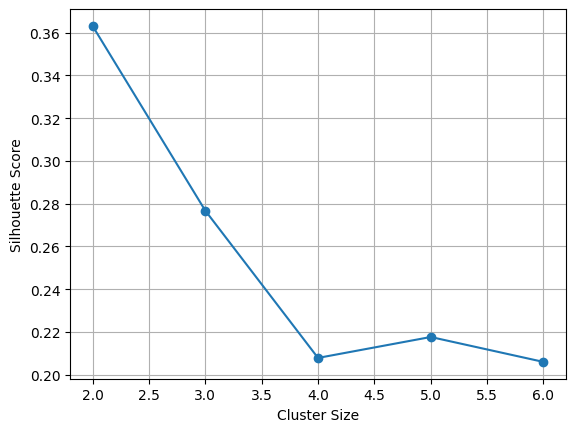

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

cluster_size_array = np.arange(2,7)
sil_score = []

for cluster_size in cluster_size_array:
  print("Starting KMeans with cluster size: ", cluster_size)
  clustering = KMeans(n_clusters=cluster_size, random_state=0)
  clustering.fit(cvd_train_vali_X)
  train_labels = clustering.labels_
  print("  - Calculating silhouette score")
  sil_score.append(silhouette_score(cvd_train_vali_X,train_labels))

plt.plot(cluster_size_array, sil_score, marker='o', linestyle='-')
plt.xlabel("Cluster Size")
plt.ylabel("Silhouette Score")

plt.grid(True)
plt.show()

Silhouette score is maximum at the cluster size 2. The may mean that the clusters are not well represented by KMeans type clusters, which are round. Therefore, Bayesian-Gaussian-Mixture model clusterting is used in the proceeding step.

#### 8.2 Bayesian-Gaussian-Mixture Clusterting

A Bayesian-Gaussian-Mixture clustering model is fit to the input training dataset. The clustering labels predicted by the model for the training input data is then added as a seperate column the the training dataset. The clustering labels predicted by the same model for the holdout testing input data is also added as a seperate column the the holdout testing dataset. Then an XGBoost model is trained and tested on the new datasets.

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.mixture import BayesianGaussianMixture

cluster_model = BayesianGaussianMixture(n_components=10, n_init=10, random_state=0)

print("Generating training set labels from clustering")
cluster_model.fit(cvd_train_vali_X)
train_labels  = cluster_model.predict(cvd_train_vali_X)
cvd_train_vali_X_clustering = cvd_train_vali_X.copy()
cvd_train_vali_X_clustering["Cluster"] = train_labels

print("Generating testing set labels from clustering")
test_labels = cluster_model.predict(cvd_holdout_X)
cvd_holdout_X_clustering = cvd_holdout_X.copy()
cvd_holdout_X_clustering["Cluster"] = test_labels

model_cxg = XGBClassifier(random_state=0)
param_grid_cxg = {'n_estimators':np.array([5,10,20]),
                 'learning_rate':np.arange(0.1,2,0.2),
                 'max_depth':np.arange(1,11,3)}

re_train = False
if load_success_cxg:
  try:
    for key, value in param_grid_cxg.items():
      if ~(np.all(param_grid_cxg[key] == saved_param_grid_cxg[key])):
        re_train = True
        break
  except:
    re_train = True
else:
  re_train = True

if re_train:
  print("Grid-search on XgBoost")
  clf_cxg = GridSearchCV(model_cxg, param_grid_cxg, return_train_score=True, scoring="accuracy", verbose=1)
  clf_cxg.fit(cvd_train_vali_X_clustering, cvd_train_vali_Y)

  train_scores_cxg = clf_cxg.cv_results_['mean_train_score']
  validation_scores_cxg = clf_cxg.cv_results_['mean_test_score']

  best_validation_score_cxg = validation_scores_cxg.max()
  best_train_score_cxg = train_scores_cxg[validation_scores_cxg.argmax()]
  best_params_cxg = clf_cxg.best_params_
  best_model_cxg = clf_cxg.best_estimator_
  best_testing_score_cxg = accuracy_score(cvd_holdout_Y,best_model_cxg.predict(cvd_holdout_X_clustering))

  saved_param_grid_cxg = param_grid_cxg
  with open(cxg_dump_path, 'wb') as f:
      pickle.dump([best_validation_score_cxg ,  best_train_score_cxg , best_testing_score_cxg, best_params_cxg, best_model_cxg,saved_param_grid_cxg], f)

Testing accuracy of Clustering complimented XGBoost model on the hold-out test are as follows.

| Model                                         | Accuracy    |
| --------------------------------------------- | ----------- |
| 9. Clustering Complimented XGBoost Classifier | 0.91999721  |

Clustering complimented classifier shows a small accuracy gain over the base XGBoost classifier. Since it is a very small gain and can be due to the randomness, the base XGBoost classifier is selected as the best classidier so far.

### 9. Model Error Analysis

#### 9.1 Fitting a Surrogate Model

For error analysis and basic global model intepretation, a decisio-tree model used to mimic the prediction of the XGBoost model. First the best XGBoost model obtained from previous analysis is fit on a part of the training and validation set. Next a decision-tree model is fit on the predictions given by the XGBoost model on the remaining part of the training and validation set.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

cvd_train2_X,cvd_erranl_X, cvd_train2_Y,cvd_erranl_Y = train_test_split(cvd_train_vali_X, cvd_train_vali_Y, test_size=0.3, random_state=0)

used_model = best_model_xg
used_model.fit(cvd_train2_X, cvd_train2_Y)

cvd_xg_predicted_Y = used_model.predict(cvd_erranl_X)

error_tree = DecisionTreeClassifier(max_depth=30)
error_tree.fit(cvd_erranl_X, cvd_xg_predicted_Y)

Tot_test_samples = cvd_erranl_X.shape[0]
Tot_trai_samples = cvd_train2_X.shape[0]

cvd_errtree_predicted_Y = error_tree.predict(cvd_erranl_X)
Tot_act_test_errors = sum(~(cvd_xg_predicted_Y == cvd_erranl_Y))
Tot_pred_test_errors = sum(~(cvd_errtree_predicted_Y == cvd_erranl_Y))
print("Actual Test Errors:", Tot_act_test_errors)
print("Predicted Test Errors:", Tot_pred_test_errors)

cvd_train2_predicted_Y = error_tree.predict(cvd_train2_X)
Tot_pred_train_errors = sum(~(cvd_train2_predicted_Y == cvd_train2_Y))
print("Predicted Train Errors:", Tot_pred_train_errors)

#### 9.2 Populating Sample Portions, Error Coverages and Error Rates Across the Decision-Tree

The training dataset has been split into two in the previous step-9.1, one part to train the surrogate model and another part for testing the surrogate model. Each sample in the surrogate model testing set is sent for prediction in the surrogate model to check which nodes in the surrogate model decision-tree and excited. This can be used to count the number of training samples and the number of training errors occured in across the surrogate model decision-tree. Similar approach is taken to count the number of testing samples and number of testing errors across the surrogate model decision-tree. The sample counts and error counts populated are later used to find the sample portions, error coverages and error rates at each node of the surrogate model decision-tree.

Error rate of a particular node is defined as the ratio between total number of errors and the total number of samples seen by the node. We can calculate both training and testing error rate for each node indivigually. Sample portion of the particular node is defined as the ratio between number of samples seen by the node and the number of samples seen by its parent node. Intuitively, the sample portion is the portion of samples go into the left and right children. Sample portions of left and right children of a node, therefore has to sum to 1. We can calculate both training and testing sample portions for each node indivigually. Error coverage of a particular node is defined as the ratio between total number of errors seen by the node and the number of errors seen by its parent node. Intuitively, the error coverage is the portion of errors go into the left and right children. Althoug, training and testing error coverages can be calculated for each node, we only use the testing error coverage.

To calculate the sample portion and the error coverage of a particular node, it is required to get the error count and the sample count of the parent node. Although left and right children of each node can be accessed through the tree_.children_left and tree_.children_right attributes of the fitted decision tree, there is no ready made attribute to access the parent node of each node. The parent node of each node can be calculated using left and right children node arrays. The next step is to populate a numpy array which consists of parent node of each node in the surrogate model decision tree.

In [ ]:
test_error_count = np.zeros(error_tree.tree_.node_count)
trai_error_count = np.zeros(error_tree.tree_.node_count)
test_sampl_count = np.zeros(error_tree.tree_.node_count)
trai_sampl_count = np.zeros(error_tree.tree_.node_count)

#Count the Number of Testing Samples and Testing Errors Across the Decision-Tree
for i in np.arange(0,cvd_erranl_X.shape[0]):
  test_err = ~(best_model_xg.predict(cvd_erranl_X.iloc[[i]]) == cvd_erranl_Y.iloc[[i]])
  test_err = test_err.iloc[0]
  test_error_count[np.array(error_tree.decision_path(cvd_erranl_X.iloc[[i]]).toarray(), dtype=bool)[0]] = test_error_count[np.array(error_tree.decision_path(cvd_erranl_X.iloc[[i]]).toarray(), dtype=bool)[0]] + test_err
  test_sampl_count[np.array(error_tree.decision_path(cvd_erranl_X.iloc[[i]]).toarray(), dtype=bool)[0]] = test_sampl_count[np.array(error_tree.decision_path(cvd_erranl_X.iloc[[i]]).toarray(), dtype=bool)[0]] + 1

#Count the Number of Training Samples and Training Errors Across the Decision-Tree
for i in np.arange(0,cvd_train2_X.shape[0]):
  train_err = ~(best_model_xg.predict(cvd_train2_X.iloc[[i]]) == cvd_train2_Y.iloc[[i]])
  train_err = train_err.iloc[0]
  trai_error_count[np.array(error_tree.decision_path(cvd_train2_X.iloc[[i]]).toarray(), dtype=bool)[0]] = trai_error_count[np.array(error_tree.decision_path(cvd_train2_X.iloc[[i]]).toarray(), dtype=bool)[0]] + train_err
  trai_sampl_count[np.array(error_tree.decision_path(cvd_train2_X.iloc[[i]]).toarray(), dtype=bool)[0]] = trai_sampl_count[np.array(error_tree.decision_path(cvd_train2_X.iloc[[i]]).toarray(), dtype=bool)[0]] + 1

#Calculate and populate the parentID of each node
error_tree_parentId = np.zeros(error_tree.tree_.node_count)
error_tree_parentId[0] = -1
for i in np.arange(0,error_tree.tree_.node_count):
  if (error_tree.tree_.children_left[i] != -1):
    error_tree_parentId[error_tree.tree_.children_left[i]] = i
    error_tree_parentId[error_tree.tree_.children_right[i]] = i
error_tree_parentId = error_tree_parentId.astype(int)

#Calculate the sample portions, error rates and error coverages of each node of the decision-tree
sampl_portion_test = np.zeros(error_tree.tree_.node_count)
sampl_portion_trai = np.zeros(error_tree.tree_.node_count)
error_coverag_test = np.zeros(error_tree.tree_.node_count)
error_rate_test = np.zeros(error_tree.tree_.node_count)
error_rate_trai = np.zeros(error_tree.tree_.node_count)
sampl_portion_test[0] = 1
sampl_portion_trai[0] = 1
error_coverag_test[0] = 1
error_rate_test[0] = test_error_count[0]/test_sampl_count[0]
error_rate_trai[0] = trai_error_count[0]/trai_sampl_count[0]
for i in np.arange(1,error_tree.tree_.node_count):
  error_rate_test[i] = test_error_count[i]/test_sampl_count[i]
  error_rate_trai[i] = trai_error_count[i]/trai_sampl_count[i]
  sampl_portion_test[i] = test_sampl_count[i]/test_sampl_count[error_tree_parentId[i]]
  sampl_portion_trai[i] = trai_sampl_count[i]/trai_sampl_count[error_tree_parentId[i]]
  error_coverag_test[i] = test_error_count[i]/test_error_count[error_tree_parentId[i]]
error_rate_test = error_rate_test.round(4)
error_rate_trai = error_rate_trai.round(4)
sampl_portion_test = sampl_portion_test.round(4)
sampl_portion_trai = sampl_portion_trai.round(4)
error_coverag_test = error_coverag_test.round(4)

#### 9.3 Visualize Surrogate Model Decision-Tree

Surrogate model decision-tree is first exported using the export_graphviz method in sklearn.tree. Then the exported graph is edited to include calculated sample portions, error rates and error coverages. The graph is saved as a pdf file in Error_Tree.pdf.

In [ ]:
from sklearn.tree import export_graphviz
import graphviz
import pydot
import networkx as nx

dot_data = export_graphviz(error_tree,
                           out_file=None,
                           max_depth=5,
                           rounded=True,
                           special_characters=True)

dot_graph = pydot.graph_from_dot_data(dot_data)[0]

MG = nx.nx_pydot.from_pydot(dot_graph)

for n in list(MG.nodes(data=True)):
  if n[0].isnumeric():
    int_n = int(n[0])
    MG.nodes[n[0]]['label'] = f"""Sample_Portion_Test = {sampl_portion_test[int_n]}
                                  \nSample_Portion_Train = {sampl_portion_trai[int_n]}
                                  \nError_Coverage_Test = {error_coverag_test[int_n]}
                                  \nError_Rate_Test = {error_rate_test[int_n]}
                                  \nError_Rate_Train = {error_rate_trai[int_n]}
                                  \n{cvd_train2_X.columns[error_tree.tree_.feature[int_n]]} ≤ {error_tree.tree_.threshold[int_n]}"""
  else:
    break

new_dot_graph = nx.nx_pydot.to_pydot(MG)
new_dot_graph.write_pdf("Error_Tree.pdf")

Upon a closer inspection of the Error_Tree pdf file, its  noted that the error rates are considerably high when General_Health <= 0.5, although it contributes to only about 14% of the total errors occured from the model. This can be due to fact that the portion of samples with General_Health <= 0.5 satisfied is small. However, it can also be noted that the traning and testing errors have considerable disparity, which might suggest overfitting in the sample cohort of General_Health <= 0.5. Therefore, we can try to upsample and downsample the cohort and fit the XGBoost model again to check for a accuracy gain.

To use Sklearn GridSearchCV to find the best upsampling and downsampling ratios, we need to develop a custom Sklearn estimator with cohort resampling capability. 

### 10. Custom Resampling Classifier

#### 10.1 Class Definition for Custom Resampling Classifier

Cohort1 is defined as the set of samples with General_Health > 0.5 and Cohort2 is defined as the set of samples with General_Health <= 0.5. The custom classifier takes in sampling rates for cohort1 and cohort2, which can be any positive real number. Each cohort is upsampled or downsampled according the sampling rates given and a base classifier (XGBoost by default) is fitted on the resampled dataset. 

In [ ]:
from sklearn.base import BaseEstimator
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.utils import shuffle
import math
import pandas as pd

class ResampledEstimator(BaseEstimator):

    def __init__(self,
                 cohort1_ratio = 1,
                 cohort2_ratio = 1,
                 replace = True,
                 random_state = None,
                 base_estimator = XGBClassifier(),
                 **kwargs):
      self.cohort1_ratio = cohort1_ratio
      self.cohort2_ratio = cohort2_ratio
      self.replace = replace
      self.random_state = random_state
      self.model = base_estimator.set_params(**kwargs)

    def fit(self, X, y):
      Xy = pd.concat([X,y],axis=1)
      cohort1 = Xy[Xy["General_Health"] > 0.5]
      cohort2 = Xy[Xy["General_Health"] <= 0.5]

      resamp_cohort1 = resample(cohort1,
                                replace=self.replace,
                                random_state=0,
                                n_samples=int(math.ceil(self.cohort1_ratio*cohort1.shape[0])))
      resamp_cohort2 = resample(cohort2,
                                replace=self.replace,
                                random_state=0,
                                n_samples=int(math.ceil(self.cohort2_ratio*cohort2.shape[0])))
      Xy = pd.concat([resamp_cohort1,resamp_cohort2])
      Xy = shuffle(Xy,random_state=self.random_state)
      Y = Xy.pop("Heart_Disease")
      X = Xy
      return self.model.fit(X, Y)

    def predict(self, X):
      return self.model.predict(X)

    def classes_(self):
      if self.model:
        return self.model.classes_

    def set_params(self, **params):
      if not params:
        return self
      if "cohort1_ratio" in params.keys():
        self.cohort1_ratio = params["cohort1_ratio"]
        params.pop("cohort1_ratio")
      if "cohort2_ratio" in params.keys():
        self.cohort2_ratio = params["cohort2_ratio"]
        params.pop("cohort2_ratio")
      self.model = self.model.set_params(**params)
      return self

    def get_params(self, deep=True):
      out = {"cohort1_ratio": self.cohort1_ratio, "cohort2_ratio": self.cohort2_ratio}
      out.update(self.model.get_params(deep=True))
      return out

#### 10.2 Hyper-Parameter Tuning for Custom Resamling Classifier

Other than the parameters for the base estimator (in this case the XGBoost) cohort1 and cohort2 resampling rates need to be tuned. 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

model_crs=ResampledEstimator(random_state = 0)
param_grid_crs = {'n_estimators':np.array([10,20,30]),
                  'learning_rate':np.arange(0.1,0.8,0.2),
                  'max_depth':np.arange(2,6,3),
                  'cohort1_ratio':np.arange(0.2,1.5,0.3),
                  'cohort2_ratio':np.arange(0.2,1.5,0.3)}

re_train = False
if load_success_crs:
  try:
    for key, value in param_grid_crs.items():
      if ~(np.all(param_grid_crs[key] == saved_param_grid_crs[key])):
        re_train = True
        break
  except:
    re_train = True
else:
  re_train = True

if re_train:
  clf_crs = GridSearchCV(model_crs, param_grid_crs, return_train_score=True, scoring="accuracy", verbose=3)
  clf_crs.fit(cvd_train_vali_X, cvd_train_vali_Y)

  train_scores_crs = clf_crs.cv_results_['mean_train_score']
  validation_scores_crs = clf_crs.cv_results_['mean_test_score']

  best_validation_score_crs = validation_scores_crs.max()
  best_train_score_crs = train_scores_crs[validation_scores_crs.argmax()]
  best_params_crs = clf_crs.best_params_
  best_model_crs = clf_crs.best_estimator_
  best_testing_score_crs = accuracy_score(cvd_holdout_Y,best_model_crs.predict(cvd_holdout_X))

  saved_param_grid_crs = param_grid_crs
  with open(crs_dump_path, 'wb') as f:
      pickle.dump([best_validation_score_crs,  best_train_score_crs, best_testing_score_crs, best_params_crs, best_model_crs, saved_param_grid_crs], f)

Testing accuracy of Resampling XGBoost classifier on the hold-out test are as follows.

| Model                              | Accuracy    |
| ---------------------------------- | ----------- |
| 10. Resampling XGBoost classifier  | 0.91961751  |

However, this is less than the best base estimator we obtained. Therefore, the best model is considered to be the XGBoost model.